In [1]:
!pwd

/pscratch/sd/c/cwang31/neurorient


In [2]:
# %load_ext autoreload
# %autoreload 2

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import numpy as np
import scipy

from tqdm import tqdm 

import os

import matplotlib.pyplot as plt
from neurorient.model_bifpn import NeurOrient
from neurorient.utils_visualization import save_mrc, display_volumes, display_fsc
from neurorient.reconstruction.phasing import PhaseRetriever
from neurorient.metrics import compute_fsc
from neurorient.reconstruction.slicing import real_mesh_2_reciprocal_mesh
from neurorient.utils_model     import get_radial_profile

from neurorient.configurator import Configurator
from neurorient.config import CONFIG

import h5py
from pytorch3d.transforms import matrix_to_quaternion

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/global/u2/c/cwang31/data_root/conda/envs/neurorient/lib/python3.9/site-packages/skopi/diffraction.py:76: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_phase(atom_pos, q_xyz):
/global/u2/c/cwang31/data_root/conda/envs/neurorient/lib/python3.9/site-packages/skopi/diffraction.py:90: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def cal(f_hkl, atom_pos, q_x

In [3]:
with CONFIG.enable_auto_create():
    CONFIG.BIFPN.NUM_BLOCKS = 1

In [4]:
pdb = '1BXR'
poisson = True
num_images = 10000
increase_factor = 10

In [5]:
spi_data = torch.load(f'data/{pdb}_increase{increase_factor}_poisson{poisson}_num{num_images//1000}K.pt')

In [6]:
# [[[ MODEL ]]]
# Config the channels in the network...
model_dir = 'model'
# %%
q_values, radial_profile = get_radial_profile(
    spi_data['intensities'], 
    spi_data['pixel_position_reciprocal'])

# %%
radial_scale_configs = {
    "q_values": q_values,
    "radial_profile": radial_profile,
    "alpha": 1.0
}

# %%
model = NeurOrient(spi_data['pixel_position_reciprocal'],
                   radial_scale_configs=radial_scale_configs,
                   pretrained_backbone = True)

# Set device...
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

/global/u2/c/cwang31/data_root/conda/envs/neurorient/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/global/u2/c/cwang31/data_root/conda/envs/neurorient/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NeurOrient(
  (orientation_predictor): ResNet2RotMat(
    (backbone): ImageEncoder(
      (backbone): ResNet(
        (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, mome

In [7]:
# timestamp = "2023_0918_1548_58"
# epoch = 206

# timestamp = "2023_0918_2217_10"
# epoch = 30

job_name = "bifpn_block.00"
timestamp = "2023_0922_0116_32"
epoch = 575

job_name = "bifpn_block.01"
timestamp = "2023_0922_0238_19"
epoch = 277

job_name = "bifpn_block.02"
timestamp = "2023_0922_0238_19"
epoch = 208

job_name = "bifpn_block.03"
timestamp = "2023_0922_0318_26"
epoch = 221

tag   = ""
fl_chkpt = None if timestamp is None else f"{timestamp}.epoch_{epoch}{tag}.chkpt"

if job_name is not None: fl_chkpt = f"{job_name}.{fl_chkpt}"

drc_chkpt = "experiments/chkpts"
chkpt = torch.load(os.path.join(drc_chkpt, fl_chkpt))

model.load_state_dict(chkpt['model_state_dict'])

<All keys matched successfully>

In [8]:
# spi_data = torch.load(f'/pscratch/sd/z/zhantao/neurorient_repo/data/{pdb}_increase{increase_factor:d}_poisson{poisson}_num{num_images//1000:d}K.pt')
# ckpt_path = '/pscratch/sd/z/zhantao/neurorient_repo/model/lightning_logs/version_15635334/checkpoints/1BXR-epoch=347-step=31240.ckpt'
# save_dir = '/pscratch/sd/z/zhantao/neurorient_repo/data'
# print(spi_data.keys())

In [9]:
# model = NeurOrient.load_from_checkpoint(ckpt_path)
# scale_factor = model.photons_per_pulse * 1e-12

In [10]:
# model.to(device)

# grid_reciprocal = np.pi * model.grid_position_reciprocal / model.grid_position_reciprocal.max()
# with torch.no_grad():
#     intensity = model.predict_intensity(grid_reciprocal.to(device))
# intensity_pred = (torch.exp(intensity) - 1).cpu().numpy() / scale_factor

In [11]:
scale_factor = model.photons_per_pulse * 1e-12
scale_factor

10.0

In [12]:
grid_reciprocal = np.pi * model.grid_position_reciprocal / model.grid_position_reciprocal.max()
with torch.no_grad():
    intensity = model.predict_intensity(grid_reciprocal.to(device))
intensity_pred = (torch.exp(intensity) - 1).cpu().numpy() / scale_factor

In [13]:
model.grid_position_reciprocal.shape

torch.Size([128, 128, 128, 3])

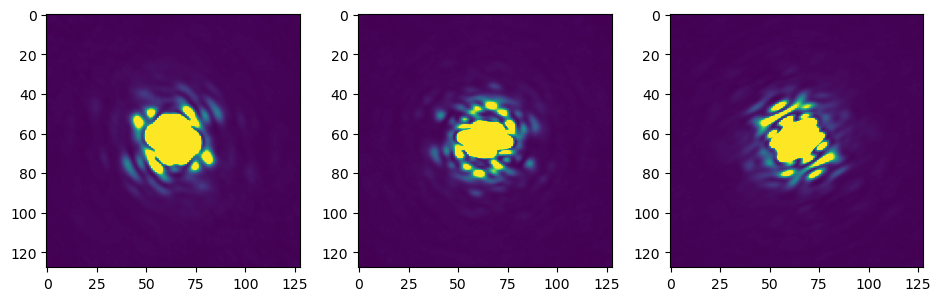

In [14]:
display_volumes(intensity_pred, closefig=False, vmin=0, vmax=1e-3 * intensity_pred.max())

In [15]:
phase_retriever = PhaseRetriever(n_phase_loops=10, beta_HIO=0.3, beta_DM=0.3, shrink_wrap_method='max')
rho_phased, support_phased = phase_retriever.phase(torch.from_numpy(intensity_pred.clip(intensity_pred.max() * 1e-5)).sqrt().to(device))

Phase Retrieval:   0%|          | 0/10 [00:00<?, ?it/s]

/global/u2/c/cwang31/data_root/conda/envs/neurorient/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Phase Retrieval: 100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


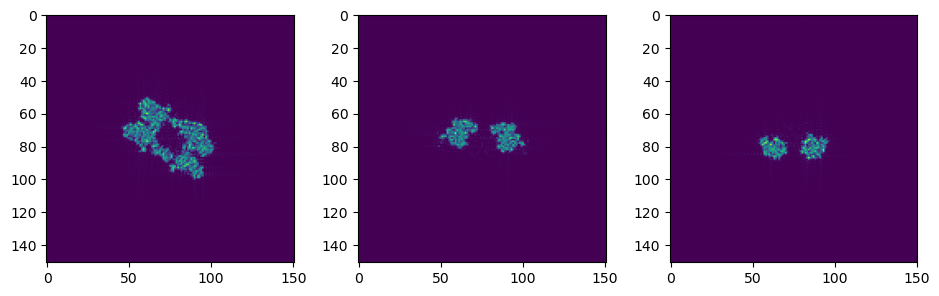

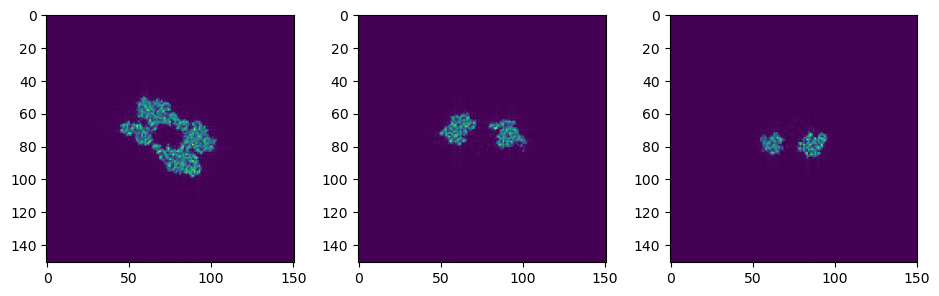

In [16]:
from neurorient.reconstruction.phasing import recenter

real_volume = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(spi_data['volume'])).real).clamp(0.)
display_volumes(real_volume, closefig=False)
real_volume = torch.fft.fftshift(recenter(
    torch.fft.ifftshift(real_volume), torch.ones_like(real_volume), M=real_volume.shape[-1]
)[0])
display_volumes(real_volume, closefig=False)

Initial CC between unzoomed / unfiltered volumes is: 0.209
Alignment CC after rotation is: 0.828
Final CC between unzoomed / unfiltered volumes is: 0.798
Estimated resolution from FSC: 25.1 Angstrom


/pscratch/sd/c/cwang31/neurorient/neurorient/utils_visualization.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  ax2.set_xticklabels([f"{1/q:.2f}" for q in ax1.get_xticks()])


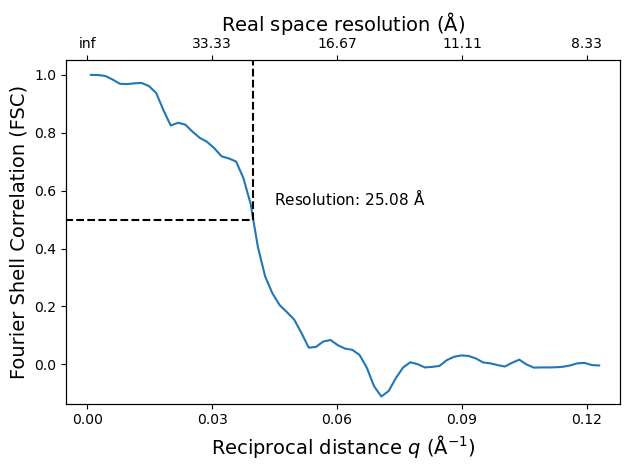

In [17]:
rho_cc, qshell, fsc = compute_fsc(
    real_volume, 
    spi_data['vol_real_mesh'], 
    rho_phased,
    model.grid_position_real,
    volume_type='electron_density')

display_fsc(qshell, fsc, resolution=rho_cc, closefig=False)

Initial CC between unzoomed / unfiltered volumes is: 0.680
Alignment CC after rotation is: 0.931
Final CC between unzoomed / unfiltered volumes is: 0.975
Estimated resolution from largest-q: at least 11.4 Angstrom


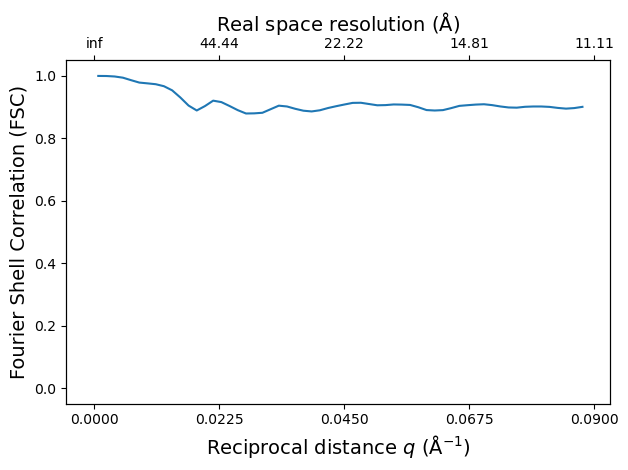

In [18]:
resolution, qshell, fsc = compute_fsc(
    spi_data['volume'].abs().pow(2) / spi_data['volume'].abs().pow(2).max(),
    real_mesh_2_reciprocal_mesh(spi_data['vol_real_mesh']), 
    intensity_pred/intensity_pred.max(),
    model.grid_position_reciprocal,
    volume_type='intensity')
display_fsc(qshell, fsc, closefig=False)

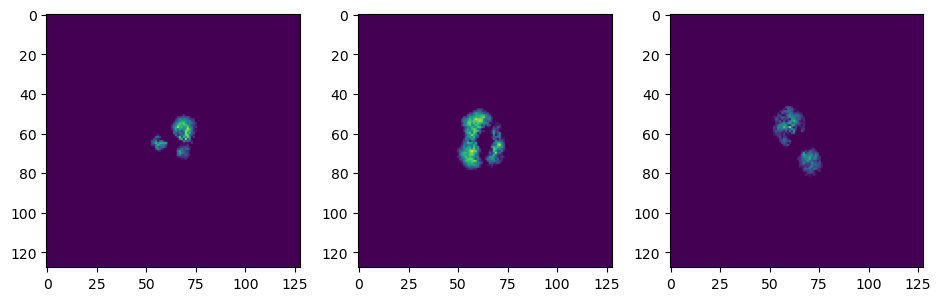

In [19]:
display_volumes(rho_phased, closefig=False, vmin=0)

In [20]:
# save_mrc(f'{pdb}_pr.mrc', rho_phased.detach().cpu().numpy())